In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env = gym.envs.make("CartPole-v0")
import time

/Users/melikaayoughi/Desktop/myfavouriteenv/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
    
    def forward(self, x):
        return self.l2(F.relu(self.l1(x)))

In [4]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) == self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)
        
        if len(self.memory) > self.capacity:
            print('push function has some error, exceeding the memory size.')

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def get_epsilon(it):
    epsilon_start = 1
    epsilon_end = 0.05
    if it <= 1000:
        epsilon = ((epsilon_end - epsilon_start)/(1000-0)) * it + epsilon_start
    else:
        epsilon = epsilon_end
    return epsilon

In [6]:
def select_action(model, state, epsilon):  
    with torch.no_grad():
        random_switch = random.uniform(0, 1)
        if random_switch <= epsilon:
            return env.action_space.sample()
        else:
            # to avoid error
            x_torch = torch.from_numpy(state).double()
            model = model.double()
            # picking max Q
            return torch.argmax(model(x_torch)).item()

In [7]:
def compute_q_val(model, state, action):
    # to avoid getting errors
    model = model.double()
    state = state.double()
    action = action[:, None]
    
    q = model(state)
    return torch.gather(q, 1, action).squeeze()
    
def compute_target(model, target_model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # to avoid getting errors
    next_state = next_state.double()
    model = model.double()
    done = done.double()
    reward = reward.double()
    target_model = target_model.double()
    
    
#     Q_max, _ = torch.max(model(next_state), dim = 1)
    action_prime = torch.argmax(target_model(next_state), dim = 1)
#     return reward + (1-done) * discount_factor * Q_max
    return reward + (1-done) * discount_factor * compute_q_val(model, next_state, action_prime)

def train(model, target_model, memory, optimizer, batch_size, discount_factor, tau):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, target_model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    for param, target_param in zip(model.parameters(), target_model.parameters()):
        target_param.data.copy_(tau * param + (1-tau) * target_param)
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [8]:
def run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    loss_history = []
    for i in range(num_episodes):
        # run the episode
        state = env.reset()
        duration = 0
        done = False
        while done == False:
            epsilon = get_epsilon(global_steps)
            action = select_action(model, state, epsilon)
            s_next, r, done, _ = env.step(action)
            transition = (state, action, r, s_next, done)
            memory.push(transition)
            state = s_next
            duration += 1
            global_steps += 1
            # call train
            loss = train(model, target_model, memory, optimizer, batch_size, discount_factor, tau)
            loss_history.append(loss)
        episode_durations.append(duration)
    return episode_durations, loss_history

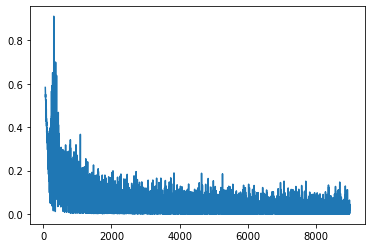

In [11]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen
tau = 1/100
# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)
target_model = QNetwork(num_hidden)

# hard copying parameters of one to the other to have the same network initialization
for target_param, param in zip(model.parameters(), target_model.parameters()):
    target_param.data.copy_(param)

episode_durations, loss_history = run_episodes(train, model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)
plt.plot(loss_history)
plt.show()

Text(0.5, 1.0, 'Episode durations per episode')

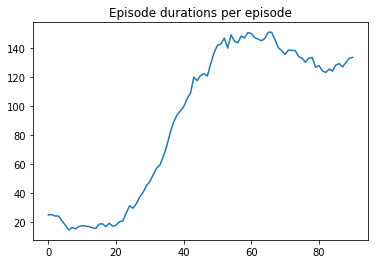

In [12]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

